In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [26]:
import os
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import random
import gc
import lightgbm as lgb
import joblib
from lightgbm import LGBMRegressor

In [122]:
calendar = pd.read_csv("/kaggle/input/m5-forecasting-accuracy/calendar.csv")
train_data = pd.read_csv("/kaggle/input/m5-forecasting-accuracy/sales_train_evaluation.csv")
sell_prices = pd.read_csv("/kaggle/input/m5-forecasting-accuracy/sell_prices.csv")
submission = pd.read_csv("/kaggle/input/m5-forecasting-accuracy/sample_submission.csv")

In [36]:
for d in range(1942,1970):
    col = 'd_' + str(d)
    train_data[col] = 0
    train_data[col] = train_data[col].astype(np.int16)

In [40]:
def downcast(df):
    cols = df.dtypes.index.tolist()
    types = df.dtypes.values.tolist()
    for i,t in enumerate(types):
        if 'int' in str(t):
            if df[cols[i]].min() > np.iinfo(np.int8).min and df[cols[i]].max() < np.iinfo(np.int8).max:
                df[cols[i]] = df[cols[i]].astype(np.int8)
            elif df[cols[i]].min() > np.iinfo(np.int16).min and df[cols[i]].max() < np.iinfo(np.int16).max:
                df[cols[i]] = df[cols[i]].astype(np.int16)
            elif df[cols[i]].min() > np.iinfo(np.int32).min and df[cols[i]].max() < np.iinfo(np.int32).max:
                df[cols[i]] = df[cols[i]].astype(np.int32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.int64)
        elif 'float' in str(t):
            if df[cols[i]].min() > np.finfo(np.float16).min and df[cols[i]].max() < np.finfo(np.float16).max:
                df[cols[i]] = df[cols[i]].astype(np.float16)
            elif df[cols[i]].min() > np.finfo(np.float32).min and df[cols[i]].max() < np.finfo(np.float32).max:
                df[cols[i]] = df[cols[i]].astype(np.float32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.float64)
        elif t == object:
            if cols[i] == 'date':
                df[cols[i]] = pd.to_datetime(df[cols[i]], format='%Y-%m-%d')
            else:
                df[cols[i]] = df[cols[i]].astype('category')
    return df  

In [41]:
print("Downcasting data")
train_eva = downcast(train_data)
sell_prices = downcast(sell_prices)
calendar = downcast(calendar)

Downcasting data


In [44]:
data = pd.read_pickle('data.pkl')
valid = data[(data['d']>=1914) & (data['d']<1942)][['id','d','sold']]
test = data[data['d']>=1942][['id','d','sold']]


In [67]:
print("Get Labels")
d_id = dict(zip(train_data["id"].cat.codes, train_data["id"]))
d_store = dict(zip(train_data["store_id"].cat.codes, train_data["store_id"]))
d_dept = dict(zip(train_data["dept_id"].cat.codes, train_data["dept_id"]))
d_cat = dict(zip(train_data["cat_id"].cat.codes, train_data["cat_id"]))

Label Encoding


In [47]:
data.columns

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd',
       'sold', 'wday', 'month', 'year', 'event_name_1', 'event_type_1',
       'sell_price', 'snap', 'weekend', 'total_sale_store', 'total_sale_dept',
       'state_mean', 'store_mean', 'cat_mean', 'dept_mean', 'state_cat_mean',
       'state_dept_mean', 'store_cat_mean', 'item_id_mean', 'item_state_mean',
       'item_store_mean', 'state_median', 'store_median', 'cat_median',
       'dept_median', 'state_cat_median', 'state_dept_median',
       'store_cat_median', 'item_id_median', 'item_state_median',
       'item_store_median', 'state_std', 'store_std', 'cat_std', 'dept_std',
       'state_cat_std', 'state_dept_std', 'store_cat_std', 'item_id_std',
       'item_state_std', 'item_store_std', 'sales_lag_5', 'sales_lag_8',
       'sales_lag_10', 'sales_lag_25', 'sales_lag_26', 'sales_lag_27',
       'sales_lag_28', 'sales_lag_29', 'sales_lag_30', 'sales_lag_31',
       'sales_lag_32', 'sales_lag_33', 'sales_lag_3

In [49]:
data = data.drop(['sales_lag_5', 'sales_lag_8','sales_lag_10', 'sales_lag_25', 'sales_lag_26', 'sales_lag_27', 'rolling_mean_tmp_7_30',
       'rolling_mean_tmp_7_60', 'rolling_mean_tmp_14_7',
       'rolling_mean_tmp_14_14', 'rolling_mean_tmp_14_30',
       'rolling_mean_tmp_14_60'], axis = 1)

In [45]:
def create_store_dataframe(train, store):
    train = train[train["id"].str.contains(store)]
    
    final_df = pd.melt(frame=train, 
                 id_vars=["id", "item_id", "dept_id", "cat_id", "store_id", "state_id"],
                 var_name="d", value_name="sold")
    sum_df = final_df.groupby(["d", "store_id"])["sold"].sum().reset_index()
    final_df = pd.merge(left=final_df.drop("sold", axis=1), right=sum_df, how="left", on=["d", "store_id"]) \
    [["store_id", "state_id", "d", "sold"]]
    final_df.drop_duplicates(inplace=True)
    
    final_df = pd.merge(left=final_df, right=calendar, how="left", on="d")
    

    final_df["d"] = final_df["d"].apply(lambda x: int(x[2:])).astype(np.int16)
    
    final_df["event_name_1"] = final_df["event_name_1"].cat.codes
    final_df["event_type_1"] = final_df["event_type_1"].cat.codes
    final_df = final_df.drop(["store_id", "state_id", "date", "weekday", "event_name_2", "event_type_2"], axis=1)
    
    X_train, y_train = final_df[final_df["d"] < 1914].drop("sold", axis=1), final_df[final_df["d"] < 1914]["sold"]
    lgb_train_sets = lgb.Dataset(X_train, y_train)
    X_valid, y_valid = final_df[(final_df["d"] >= 1914) & (final_df["d"] < 1942)].drop("sold", axis=1), final_df[(final_df["d"] >= 1914) & \
                                                                                         (final_df["d"] < 1942)]["sold"]
    lgb_valid_sets = lgb.Dataset(X_valid, y_valid)
    X_test, y_test = final_df[final_df["d"] >= 1942].drop("sold", axis=1), final_df[final_df["d"] >= 1942]["sold"] 
    
    
    return lgb_train_sets,lgb_valid_sets, X_train, y_train, X_valid, y_valid, X_test, y_test

In [27]:
params = {"objective" : "tweedie",
        'boosting_type': 'gbdt',
        'learning_rate': 0.034,
        'max_depth' : 135,
        'num_leaves': 88,
        'n_estimators': 1000,
        'force_row_wise':True,
        'lambda_l2':1
}

In [60]:
def create_store_model(train_data, store_id):
    train_sets, valid_sets, X_train, y_train, X_valid, y_valid, X_test, y_test = create_store_dataframe(train_data, store_id)
    new_index = y_test.index.map(lambda x: x + 1)
    y_test.index = new_index

    store_model = lgb.train(params=params,
                            train_set=train_sets,
                            valid_sets=valid_sets,
                            verbose_eval=50,
                            early_stopping_rounds=50)

    store_preds = store_model.predict(X_test)
    store_preds_map = dict(pd.Series(store_preds, index=y_test.index))

    return store_preds_map

In [61]:
def train_and_predict(df, store_id, store_preds_map):
    df_store = df[df["store_id"] == store_id]
    df_store.loc[df_store["d"] >= 1942, "total_sale_store"] = df_store.loc[df_store["d"] >= 1942, :]["d"].map(store_preds_map)

    # Create train set
    X_train, y_train = df_store[df_store['d'] < 1914].drop('sold', axis=1), df_store[df_store['d'] < 1914]['sold']
    train_sets = lgb.Dataset(X_train, y_train)

    X_valid, y_valid = df_store[(df_store['d'] >= 1914) & (df_store['d'] < 1942)].drop('sold', axis=1), \
                       df_store[(df_store['d'] >= 1914) & (df_store['d'] < 1942)]['sold']
    valid_sets = lgb.Dataset(X_valid, y_valid)

    X_test = df_store[df_store["d"] >= 1942].drop("sold", axis=1)

    model = lgb.train(params=params,
                      train_set=train_sets,
                      valid_sets=valid_sets,
                      verbose_eval=50,
                      early_stopping_rounds=50)

    pred_val = model.predict(X_valid)
    valid.loc[X_valid.index, "sold"] = pred_val

    pred_eva = model.predict(X_test)
    test.loc[X_test.index, "sold"] = pred_eva

    joblib.dump(model, f'model_store_{store_id}.pkl')
    del model, X_train, y_train, X_valid, y_valid, X_test, train_sets, valid_sets
    gc.collect()

In [70]:
model = joblib.load("/kaggle/working/model_store_0.pkl")

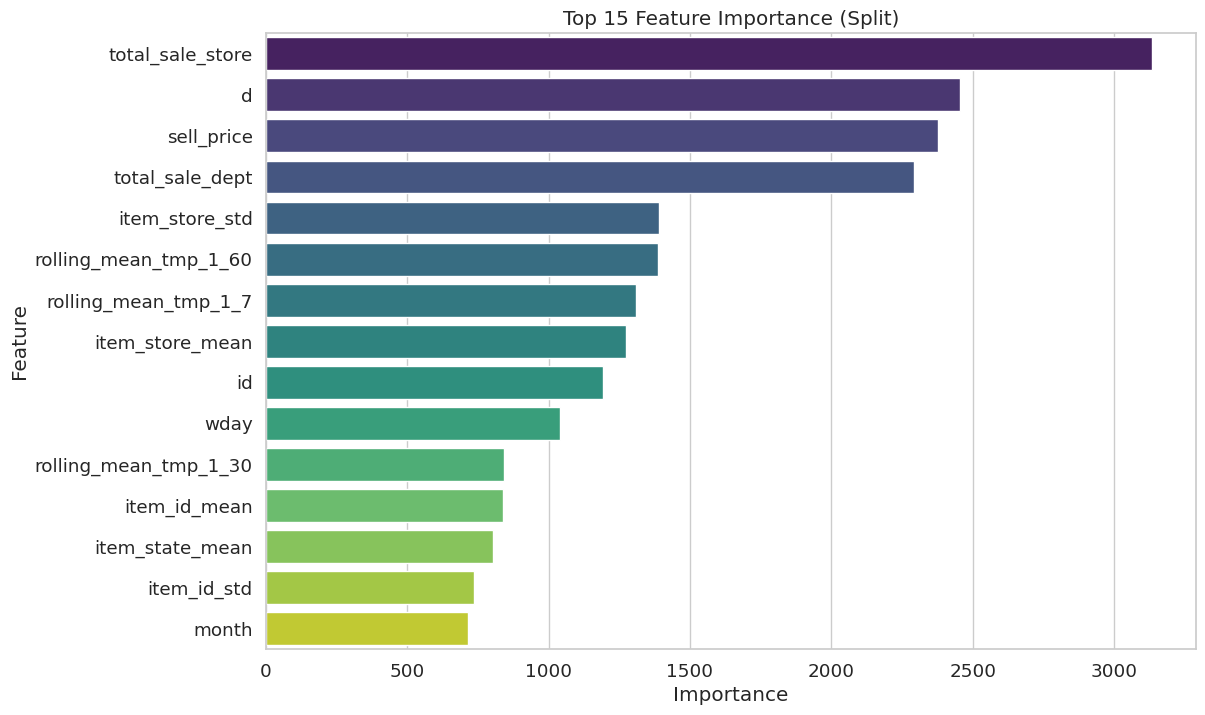

In [73]:
import seaborn as sns

# Get feature importances
feature_importance = pd.DataFrame({'Feature': model.feature_name(), 'Importance': model.feature_importance(importance_type='split')})
top_features = feature_importance.nlargest(15, 'Importance')

# Plot feature importance with Seaborn styling
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid", font_scale=1.2)

# Plot only the top 15 features with different colors
sns.barplot(x='Importance', y='Feature', data=top_features, palette='viridis')

# Customize plot further if needed
plt.title('Top 15 Feature Importance (Split)')
plt.show()

In [123]:
valid = data[(data['d']>=1914) & (data['d']<1942)][['id','d','sold']]
test = data[data['d']>=1942][['id','d','sold']]

In [120]:
valid.head()

,id,d,sold
58330419,14371,1914,0.628823
58330420,14381,1914,0.184853
58330421,14391,1914,0.391331
58330422,14401,1914,2.502708
58330423,14411,1914,1.230558


In [124]:
valid["id"] = valid["id"].map(d_id)
valid = valid.pivot(index="id", columns="d", values="sold").reset_index()
valid["id"] = valid["id"].str.replace("evaluation", "validation")

submission = submission[["id"]]

f_col = [f"F{i}" for i in range(1,29)]
f_col.insert(0, "id")

out_val = pd.merge(left=submission[:30490], right=valid, on="id")
out_val.columns=f_col
print(len(out_val))

test["id"] = test["id"].map(d_id)
test = test.pivot(index="id", columns="d", values="sold").reset_index()

out_eva = pd.merge(left=submission[30490:], right=test, on="id")
out_eva.columns=f_col
print(len(out_eva))

submit = pd.concat([out_val,out_eva], ignore_index=True)

3049
3049


In [97]:
submit.to_csv('submission.csv',index=False)